# Lab Meeting 10/2/20: 

## Can we use deep learning to detect grooming bouts in videos?   
___   
        

# INTRODUCTION: 
  
## Convolutional Neural Networks (CNNs) have had great success in learning to categorize images 
## Can we use them to categorize different behaviors? 


<img src="lab_meeting/CNN_example.jpeg" width="1000">


# One cool idea is to transform data into images to train on CNNs: 
### Here's an example of spectrograms that were fed into a CNN for categorization!
<img src="lab_meeting/sound_examples.png" width="1000">

___

# I tried to do something similar with behavior
## Some of the tools I made along the way should be helpful

### OUTLINE:
- **STEP 1: Clean the data**
- **STEP 2: Create a training set**
- **STEP 3: Train a neural network (cloud computing with google colab)**
___

# Video clips: grooming vs. locomotion

In [1]:
import moviepy.editor as mpy
fps = 70
frame_st = 46100
frame_ed = 46400
clip = mpy.VideoFileClip("RS07082020b_08182020_frameLabeled.mp4")
clip = clip.subclip(frame_st/fps,frame_ed/fps).resize(height=360)
clip.ipython_display()

t:   2%|▏         | 5/301 [00:00<00:06, 42.74it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [2]:
fps = 70
frame_st = 500
frame_ed = 800
clip = mpy.VideoFileClip("RS07082020b_08182020_frameLabeled.mp4")
clip = clip.subclip(frame_st/fps,frame_ed/fps).resize(height=360)
clip.ipython_display()

t:   2%|▏         | 5/300 [00:00<00:05, 49.49it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# grooming vs. locomotion:
*2s timelapsed traces for each body part*

<div align="center"> 

### Grooming
<img src="lab_meeting/groom.png" width="500">


### Locomotion
<img src="lab_meeting/locomotion.png" width="500">




___

# STEP 1: CLEAN THE DATA
- ## Data from DeepLabCut often contains many labeling errors. 
- ## *Whether using B-SOID or an alternative, it is critical to feed in as high quality data as possible*
   
    - *Note: Do everything you can as early as possible in the pipeline to fix labeling errors* (**ideally at acquisition**)

### An example clip with labeling errors:


In [3]:
fps = 70
frame_st = 1200
frame_ed = 1500
clip = mpy.VideoFileClip("RS07082020b_08182020_frameLabeled.mp4")
clip = clip.subclip(frame_st/fps,frame_ed/fps).resize(height=360)
clip.ipython_display()

t:   2%|▏         | 5/300 [00:00<00:06, 45.99it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


___
# A tool for cleaning DeepLabCut labels:
### Create a DataCleaner Object:

In [4]:
from DataCleaner import *
D = DataCleaner('RS07082020b_08182020.csv')

**This creates a pandas dataframe for x,y coordinates and confidence ratings based on your DeepLabCut results**

In [5]:
D.x.head()

,nose,pawFR,pawFL,pawBR,pawBL,tail
0,499.223720,503.919424,524.115105,511.212088,575.681210,622.010555
1,496.063441,505.496055,525.032511,511.366766,575.651817,621.839713
2,495.281291,508.438424,527.411820,511.596043,575.520032,622.026721
3,494.945432,509.784084,529.444952,512.273604,575.464219,622.006624
4,493.764820,512.501348,531.084946,512.275535,575.797105,622.072203


**I also included handy access to frame-by-frame displacements:**

*(Number of pixels that each label moves per frame*)

In [6]:
D.disp.head()

,nose,pawFR,pawFL,pawBR,pawBL,tail
0,NaN,NaN,NaN,NaN,NaN,NaN
1,5.811134,1.776998,1.108697,0.183521,0.091905,0.306134
2,3.617367,3.334555,2.440191,0.230163,0.135387,0.224149
3,3.527570,2.171752,2.073595,0.680334,0.092873,0.512050
4,4.853571,2.822162,1.788344,0.256781,0.341145,0.098016


**We can take advantage of functionality built into pandas**

For example, the describe() method gives quick overview of stats (front of mouse is faster than back which makes sense)

In [7]:
# Displacement statistics: 
D.disp.describe()

,nose,pawFR,pawFL,pawBR,pawBL,tail
count,122170.000000,122170.000000,122170.000000,122170.000000,122170.000000,122170.000000
mean,5.581738,6.751584,5.825591,3.171183,3.189119,2.006559
std,27.498143,41.310354,31.007533,26.879505,27.361353,3.642611
min,0.001093,0.000976,0.001284,0.000407,0.000385,0.000700
25%,0.813555,0.247670,0.252986,0.163614,0.168231,0.286518
50%,2.815279,0.630477,0.642460,0.330739,0.341789,0.848382
75%,5.794828,2.112350,2.226467,0.723268,0.752966,2.528991
max,879.893642,893.432436,864.845374,825.954619,839.773835,321.177877


### Plot of mislabeled frames from video example:

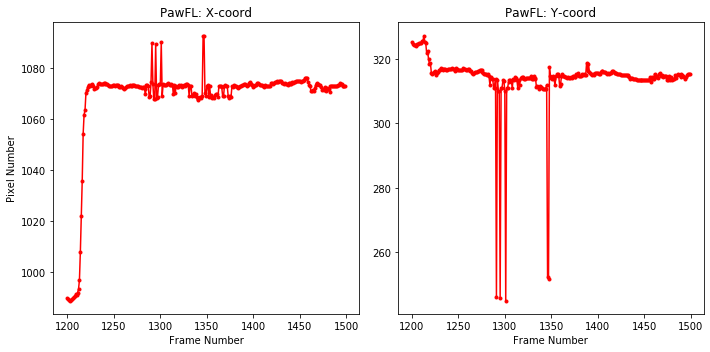

In [8]:
# Show x and y plots for the clip where the jump exists
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(D.x['pawFL'][frame_st:frame_ed],'r.-')
axes[0].set_title('PawFL: X-coord')
axes[0].set_xlabel('Frame Number')
axes[0].set_ylabel('Pixel Number')
axes[1].plot(D.y['pawFL'][frame_st:frame_ed],'r.-')
axes[1].set_title('PawFL: Y-coord')
axes[1].set_xlabel('Frame Number')
plt.tight_layout()

## Exploring the dataset:
### *Displacement plot for the entire session:*

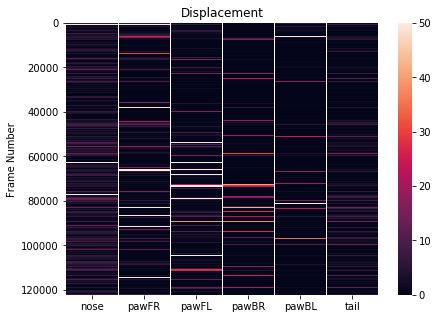

In [9]:
# Show displacement heat map:
import seaborn as sns
yticks = [x for x in range(0,D.disp.shape[0],20000)]
plt.figure(figsize=(7, 5))
ax = sns.heatmap(D.disp,vmin=0,vmax=50,xticklabels = D.body_parts,yticklabels = yticks)
ax.set_yticks(yticks)
ax.set_title('Displacement')
ax.set_ylabel('Frame Number')
plt.show()

### Low confidence frames (based on DeepLabCut results):

[[]]

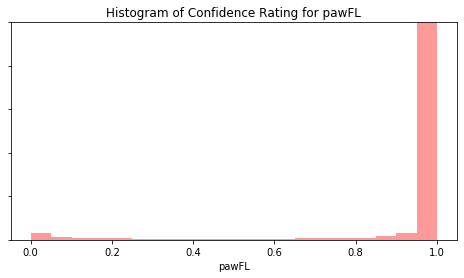

In [10]:
# Histogram of likelihoods for each bodypart: 
fig,axes = plt.subplots(1,1,figsize=(8,4))
sns.distplot(D.conf.iloc[:,2],kde=False,bins=20,color='red')
axes.set_ylabel('')
axes.set_title('Histogram of Confidence Rating for pawFL')
axes.set_ylim(0,50000)
axes.set(yticklabels=[])

___
## Built-in methods to clean the data:
### Remove low confidence frames

In [11]:
D.remove_low_likelihood(.1) # Remove any label with confidence < 10%

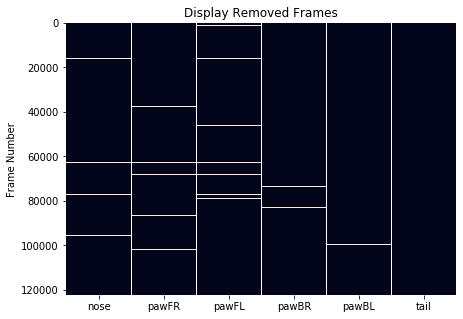

In [12]:
# display removed frames: (don't show scale)
yticks = [x for x in range(0,D.disp.shape[0],20000)]
plt.figure(figsize=(7, 5))
ax = sns.heatmap(D.x.isnull(),xticklabels = D.body_parts,yticklabels = yticks, cbar=False)
ax.set_yticks(yticks)
ax.set_title('Display Removed Frames')
ax.set_ylabel('Frame Number')
plt.show()

### Remove frames where large jumps are detected:

In [13]:
D.remove_jumps(40) # Remove any jumps creater than 40 pixels

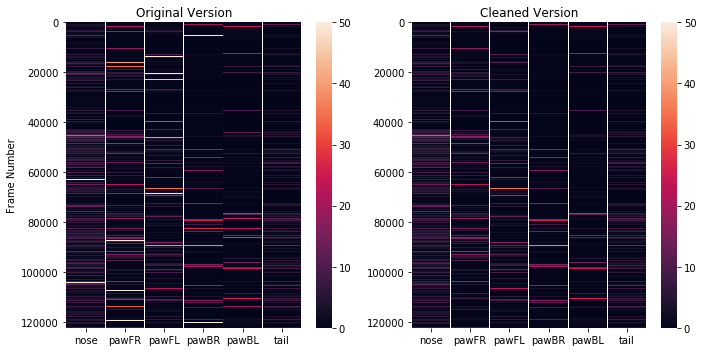

In [14]:
# Compare results:
D_old = DataCleaner('RS07082020b_08182020.csv')
yticks = [x for x in range(0,D.disp.shape[0],20000)]
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(D_old.disp,vmin=0,vmax=50,xticklabels=D.body_parts,yticklabels=yticks, ax=axes[0])
sns.heatmap(D.disp,vmin=0,vmax=50,xticklabels=D.body_parts,yticklabels=yticks, ax=axes[1])
axes[0].set_yticks(yticks)
axes[0].set_title('Original Version')
axes[0].set_ylabel('Frame Number')
axes[1].set_yticks(yticks)
axes[1].set_title('Cleaned Version')
plt.tight_layout()

### Interpolate missing values:

In [15]:
D.interpolate()

### Cleaned example segment:

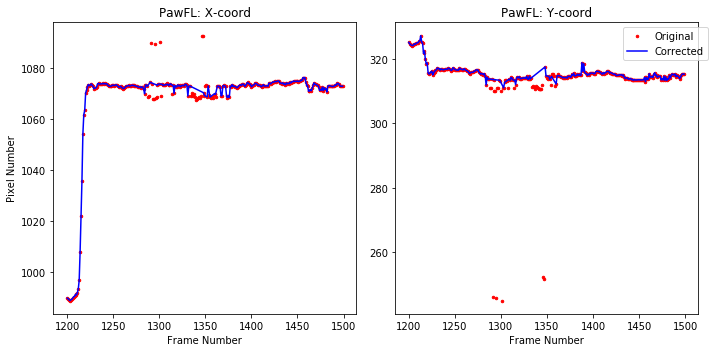

In [16]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(D_old.x['pawFL'][frame_st:frame_ed],'r.',markersize=5)
axes[0].plot(D.x['pawFL'][frame_st:frame_ed],'b')
axes[0].set_title('PawFL: X-coord')
axes[0].set_ylabel('Pixel Number')
axes[0].set_xlabel('Frame Number')
axes[1].plot(D_old.y['pawFL'][frame_st:frame_ed],'r.',markersize=5)
axes[1].plot(D.y['pawFL'][frame_st:frame_ed],'b')
axes[1].set_title('PawFL: Y-coord')
axes[1].set_xlabel('Frame Number')
axes[1].legend(['Original','Corrected'],bbox_to_anchor=(1.05, 1))
plt.tight_layout()


### Write to a new .csv file in the orignal DLC format:


In [17]:
D.write_csv('RS07082020b_08182020_cleaned.csv')

### Removing frames where labels get swapped:

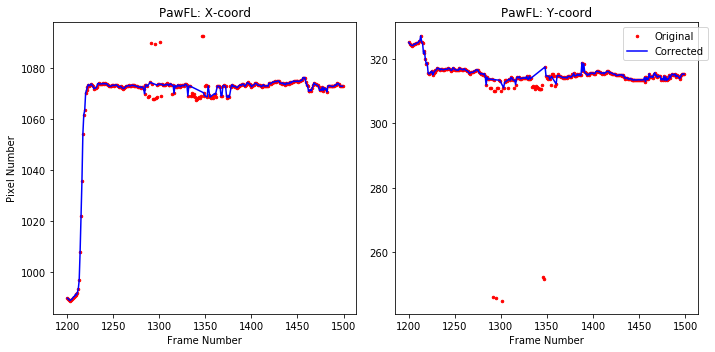

In [18]:
D = DataCleaner('RS07082020b_08182020.csv')
D.remove_low_likelihood(.1) # Remove any label with confidence < 10%
D.remove_body_swaps() # Remove frames that jump close to other body parts
D.interpolate()

# plot results:
D_old = DataCleaner('RS07082020b_08182020.csv')
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(D_old.x['pawFL'][frame_st:frame_ed],'r.',markersize=5)
axes[0].plot(D.x['pawFL'][frame_st:frame_ed],'b')
axes[0].set_title('PawFL: X-coord')
axes[0].set_ylabel('Pixel Number')
axes[0].set_xlabel('Frame Number')
axes[1].plot(D_old.y['pawFL'][frame_st:frame_ed],'r.',markersize=5)
axes[1].plot(D.y['pawFL'][frame_st:frame_ed],'b')
axes[1].set_title('PawFL: Y-coord')
axes[1].set_xlabel('Frame Number')
axes[1].legend(['Original','Corrected'],bbox_to_anchor=(1.05, 1))
plt.tight_layout()



## Cleaning methods are still a work in progress:
- ### This is just a first-pass attempt
    - It still doesn't handle cases very well where large chunks of contiguous frames are mislabeled
- ### There are probably unique problems related to each experiment
    - Occlusion (position of camera)
    - quality of video (lighting, focus, exposure)
    - difficult to label body parts

- ### Please try out some of these tools! That is the only way they will improve

___
# Adding label with grooming bouts:

Text(51.0, 0.5, 'Frame Number')

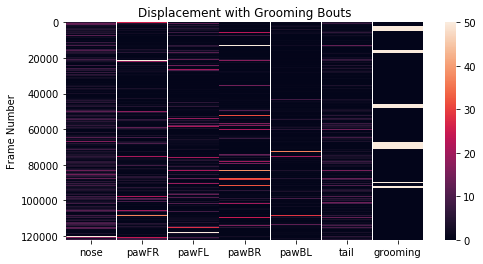

In [19]:
# Include label column
df_labels = pd.read_csv('grooming_labels.csv')
labels = np.zeros([D.disp.shape[0],1])
for bout in range(df_labels.shape[0]):
    labels[df_labels['Start'][bout]:df_labels['End'][bout]] = 1e6
D.disp['grooming'] = labels
# Make plot:
yticks = [x for x in range(0,D.disp.shape[0],20000)]
fig,axes = plt.subplots(1,1,figsize=(8,4))
sns.heatmap(D.disp,vmin=0,vmax=50,xticklabels=D.disp.columns,yticklabels=yticks)
axes.set_yticks(yticks)
axes.set_title('Displacement with Grooming Bouts')
axes.set_ylabel('Frame Number')



___
# STEP 2: Create a set of training images

<img src="lab_meeting/test.png" width="300">


- ### Lots of decisions need to be made: 
    - Length of each video segment (depends on timescale of behavior we care about)
    - How to include velocity information (color coded)
    - How large of a training set is needed? 
        - Do we need data augmentation? 
    - Need careful testing of parameter space to tune a model
___


# STEP 3: Train Neural Network (Cloud computing with google colab)